# 1. Importing all Libraries and model


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import joblib

# 2. Load the data

In [4]:
df = pd.read_csv(r"C:\Users\91773\Downloads\heart disease dataset.csv")
df.head()

,age,sex,chest pain,trestbps,cholesterol,fbs,ECG,heart rate,exang,oldpeak,slope,ca,thalassemia,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# 3. Quick inspection:
Look at data types and sample values to verify there were no parsing issues

In [5]:
print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['target'].value_counts())

Shape: (1025, 14)

Missing values per column:
 age            0
sex            0
chest pain     0
trestbps       0
cholesterol    0
fbs            0
ECG            0
heart rate     0
exang          0
oldpeak        0
slope          0
ca             0
thalassemia    0
target         0
dtype: int64

Target distribution:
 target
1    526
0    499
Name: count, dtype: int64


# 4. Feature groups
Define numeric & categorical features

In [6]:
num_cols = ['age','trestbps','cholesterol','heart rate','oldpeak']
cat_cols = ['sex','chest pain','fbs','ECG','exang','slope','ca','thalassemia']

# 5. EDA - Exploratory Data Analysis

1. Histograms for numeric columns show distribution and outliers

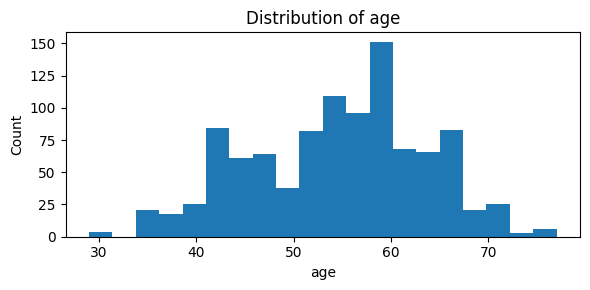

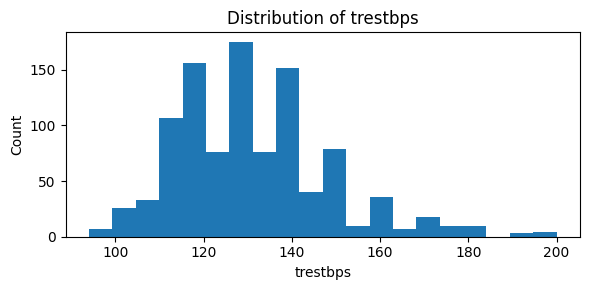

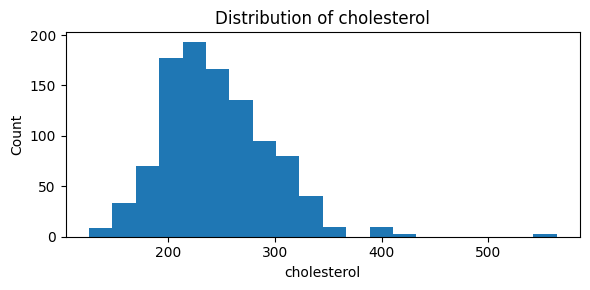

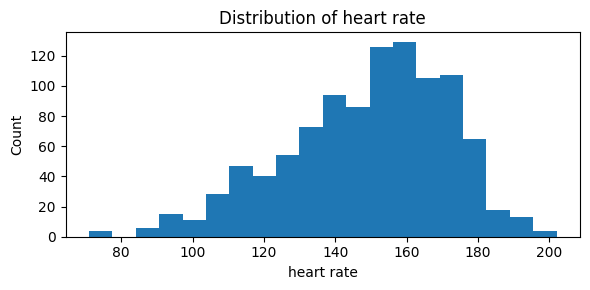

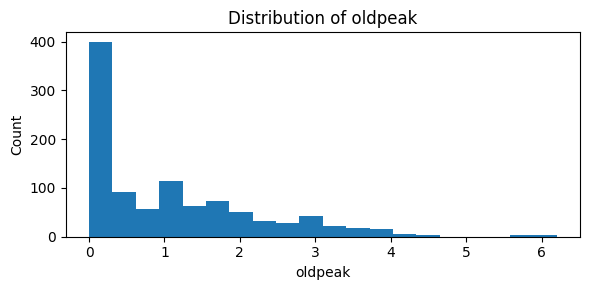

In [7]:
for col in num_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

2. Bar charts for categorical columns show counts per category

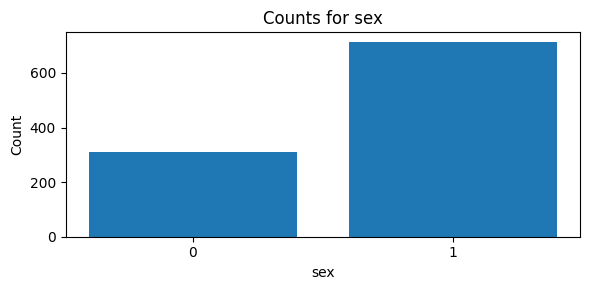

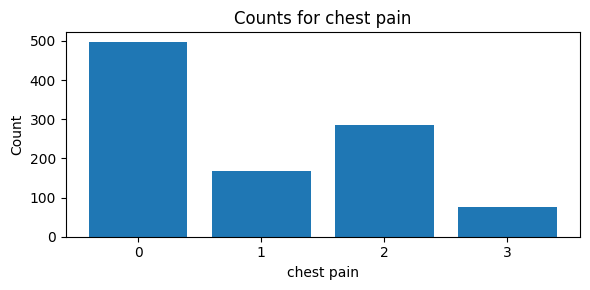

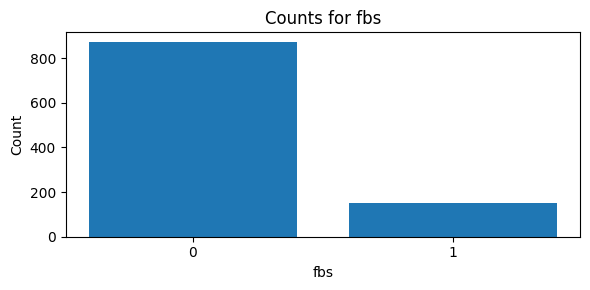

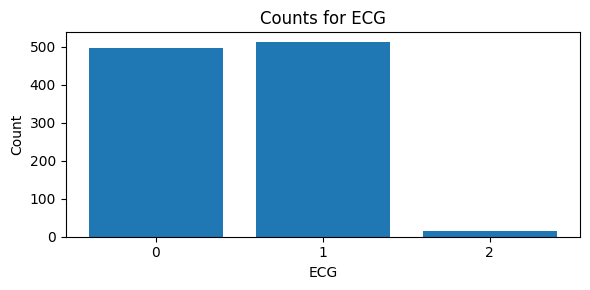

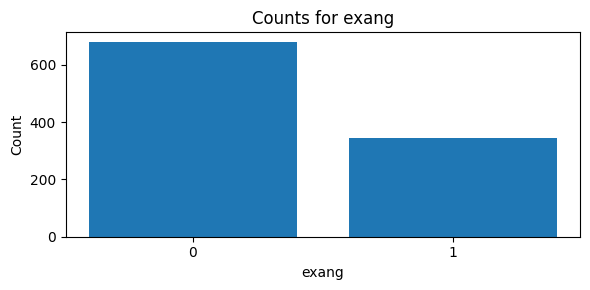

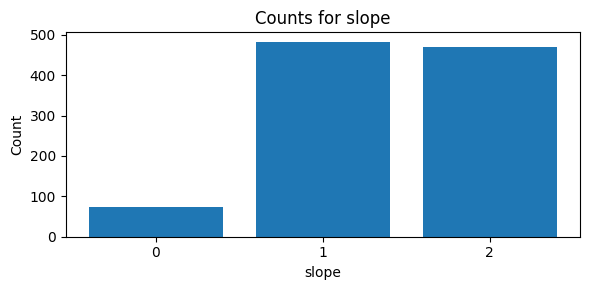

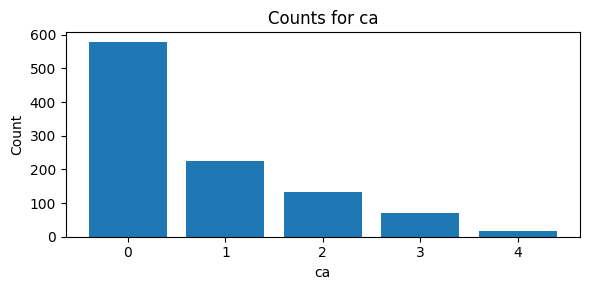

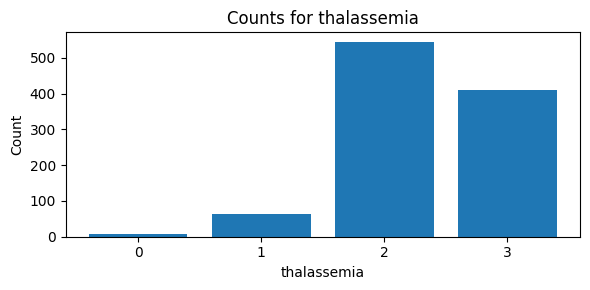

In [8]:
for col in cat_cols:
    plt.figure(figsize=(6,3))
    vals = df[col].value_counts().sort_index()
    plt.bar(vals.index.astype(str), vals.values)
    plt.title(f"Counts for {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

3. Correlation matrix shows which numeric features are linearly associated with target. This helps initial feature selection and domain insight.

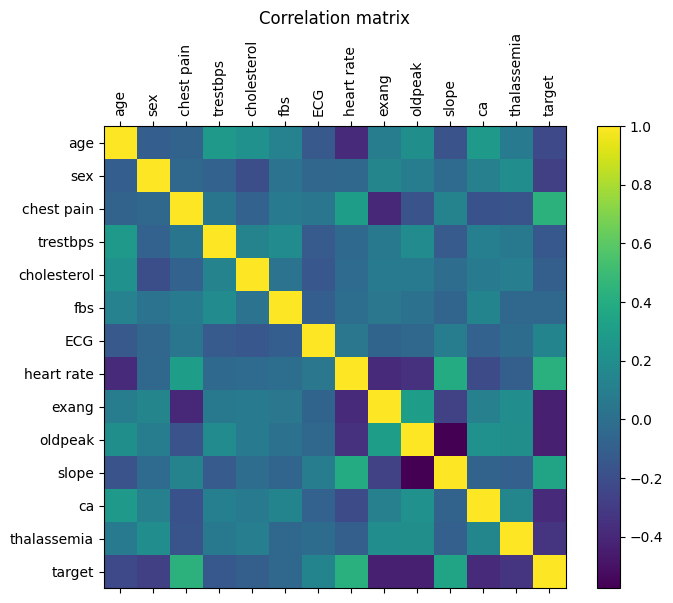


Features sorted by absolute correlation with target:
oldpeak        0.438441
exang          0.438029
chest pain     0.434854
heart rate     0.422895
ca             0.382085
slope          0.345512
thalassemia    0.337838
sex            0.279501
age            0.229324
trestbps       0.138772
ECG            0.134468
cholesterol    0.099966
fbs            0.041164
Name: target, dtype: float64


In [9]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title("Correlation matrix")
plt.show()

print("\nFeatures sorted by absolute correlation with target:")
print(corr['target'].drop('target').abs().sort_values(ascending=False))


# 6. Preprocessing pipeline and split

ColumnTransformer allows different transformations applied to different column groups:

  1.StandardScaler for numeric columns (center & scale) — necessary for many linear or distance-based models.

  2.OneHotEncoder for categorical columns so that models like Logistic Regression don’t assume ordinal relationships where none exist.

In [10]:
X = df.drop('target', axis=1)
y = df['target']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='drop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

3. We fit the transformer on training data to avoid data leakage.

In [11]:
preprocessor.fit(X_train)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


4. Get the transformed feature names (sklearn >=1.0)

In [12]:
try:
    num_features_after = num_cols
    cat_features_after = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
    feature_names = num_features_after + cat_features_after
except Exception:
    feature_names = None

# 7. Models: Logistic Regression and Random Forest (pipelines)
train_test_split(..., stratify=y) keeps class proportions in train & test, important for fair evaluation.

In [13]:
lr_pipeline = Pipeline([('preproc', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
rf_pipeline = Pipeline([('preproc', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

,steps,"[('preproc', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 8. Evaluation helper
1. Logistic Regression — simple and interpretable baseline. Good to see a linear decision boundary.
2. Random Forest — a robust tree-based ensemble that handles non-linearities and categorical interactions well.


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.8936    0.8400    0.8660       100
           1     0.8559    0.9048    0.8796       105

    accuracy                         0.8732       205
   macro avg     0.8747    0.8724    0.8728       205
weighted avg     0.8743    0.8732    0.8730       205

ROC AUC: 0.9445


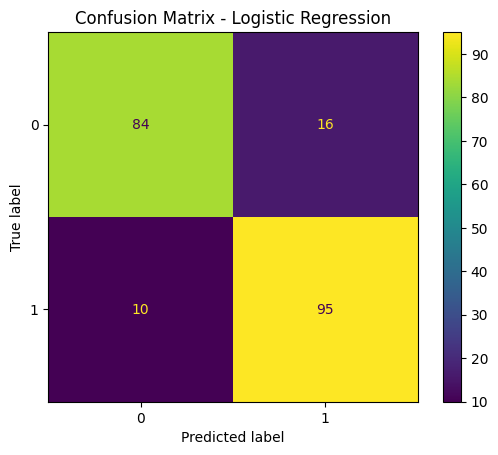

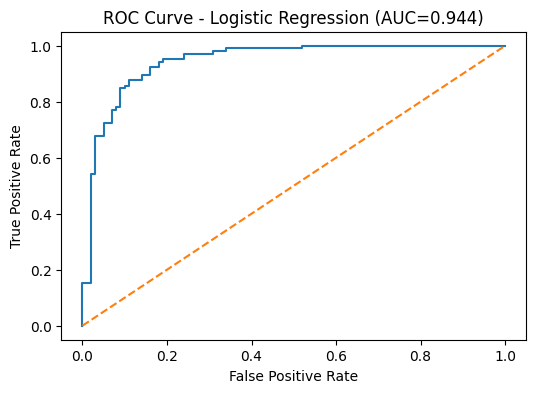


=== Random Forest ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       100
           1     1.0000    1.0000    1.0000       105

    accuracy                         1.0000       205
   macro avg     1.0000    1.0000    1.0000       205
weighted avg     1.0000    1.0000    1.0000       205

ROC AUC: 1.0000


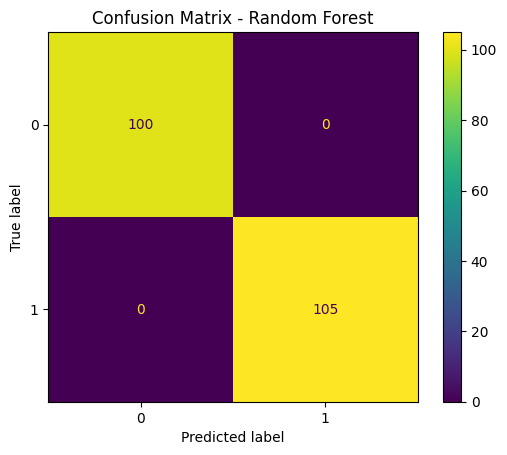

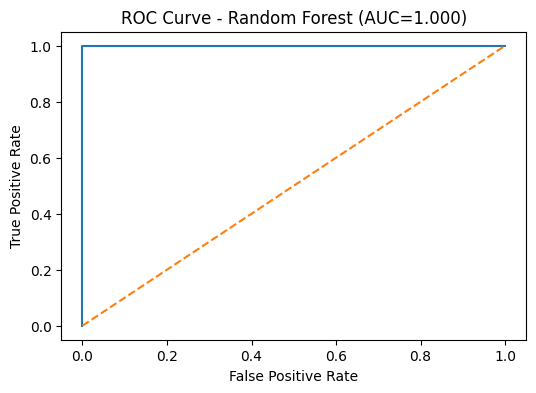

In [14]:
def evaluate_model(pipeline, X_test, y_test, name="Model"):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {auc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name} (AUC={auc:.3f})"); plt.show()
    return auc

lr_auc = evaluate_model(lr_pipeline, X_test, y_test, "Logistic Regression")
rf_auc = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")

# 9. Cross-validation ROC AUC check
1. classification_report provides precision, recall, F1 for each class.
2. For medical diagnosis, recall (sensitivity) for the disease class (label 1) is often most important: you want to minimize false negatives.
3. confusion_matrix / display shows raw TP / TN / FP / FN counts — very helpful to explain errors.
4. roc_auc_score and ROC curve measure ranking ability across thresholds; AUC closer to 1 is better.
5. Cross-validation with StratifiedKFold gives you a sense of how stable model performance is across splits.

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nCross-validated ROC AUC (5-fold):")
print("Logistic:", cross_val_score(lr_pipeline, X, y, cv=cv, scoring='roc_auc').mean())
print("RandomForest:", cross_val_score(rf_pipeline, X, y, cv=cv, scoring='roc_auc').mean())


Cross-validated ROC AUC (5-fold):
Logistic: 0.9376503798088704
RandomForest: 1.0


# 10. Random Forest feature importances
1. Random Forest gives importance scores that help you understand which processed features contributed most. 
    If you used OneHotEncoder, each category becomes a feature — the names printed help interpret (e.g., thal_2 meaning thal coded value).
2. Plot top 10


Top feature importances:
chest pain_0     0.093907
heart rate       0.092890
oldpeak          0.085669
age              0.080728
thalassemia_2    0.080021
ca_0             0.074814
cholesterol      0.067222
thalassemia_3    0.058405
trestbps         0.056224
exang_0          0.044837
exang_1          0.041428
slope_2          0.029517
chest pain_2     0.026344
slope_1          0.018874
sex_1            0.018498
dtype: float64


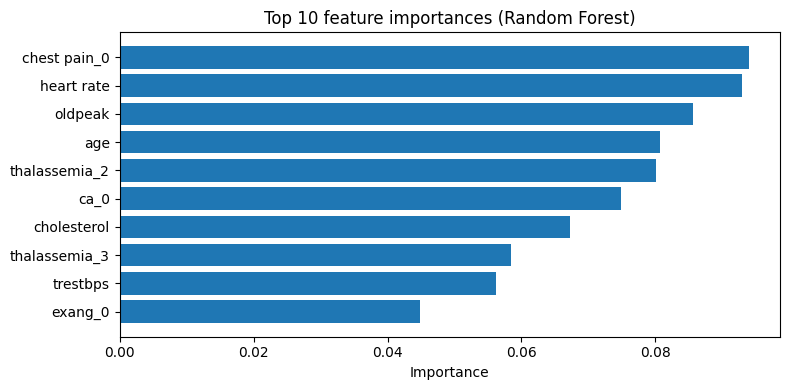

In [16]:
rf_clf = rf_pipeline.named_steps['clf']
if feature_names is not None and len(feature_names) == rf_clf.feature_importances_.shape[0]:
    importances = pd.Series(rf_clf.feature_importances_, index=feature_names).sort_values(ascending=False)
else:
    importances = pd.Series(rf_clf.feature_importances_).sort_values(ascending=False)
print("\nTop feature importances:")
print(importances.head(15))

topk = importances.head(10)
plt.figure(figsize=(8,4))
plt.barh(range(len(topk)), topk.values)
plt.yticks(range(len(topk)), topk.index)
plt.gca().invert_yaxis()
plt.title("Top 10 feature importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 11. Save final pipeline (Random Forest) to disk
Save pipeline with joblib.dump. The saved pipeline includes preprocessors so you can call pipeline.predict() directly on raw inputs later (good for deployment).

In [17]:
joblib.dump(rf_pipeline, "heart_rf_pipeline.joblib")
print("Saved Random Forest pipeline to heart_rf_pipeline.joblib")

Saved Random Forest pipeline to heart_rf_pipeline.joblib


In [22]:
!pip install streamlit



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
